# SVM and Voting Classifiers for Medical Diagnosis (Python)

This notebook investigates supervised classification models for medical diagnosis using the UCI Breast Cancer Wisconsin (Diagnostic) dataset.

The analysis focuses on:
- Support Vector Machine (SVM) classification with feature scaling and hyperparameter tuning  
- Voting Classifier ensembles that combine multiple base models to improve robustness and recall  

The goal is to study how different classification strategies behave when false negatives are costly, and how model choice, hyperparameters, and decision strategies affect precision–recall trade-offs.

*Disclaimer*: Some concepts and code patterns are adapted from lecture materials and references, including Hands-On Machine Learning (Géron, 2019).

**Importing the libraries**

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Introduction

Medical diagnosis tasks often involve imbalanced data and asymmetric error costs, where missing a positive case can have serious consequences.

In this notebook, recall is treated as the primary objective. I first examine how a tuned SVM performs under this constraint, then explore whether a Voting Classifier can further improve robustness by combining diverse models. The analysis emphasizes recall-oriented model selection, threshold adjustment, and the trade-offs introduced by ensemble methods.


## 2. Support Vector Machine Classifier

This section investigates the use of a **Support Vector Machine (SVM)** to
distinguish malignant from benign breast cytology samples using the
Diagnostic Wisconsin Breast Cancer Dataset.

The objective is to understand how SVM performance is affected by
preprocessing choices, kernel selection, hyperparameter tuning, and
decision threshold adjustment, with particular emphasis on **recall** for
malignant cases, which is critical in medical screening tasks.

The analysis proceeds through:
- data exploration and preprocessing,
- stratified train–test splitting,
- model training and hyperparameter tuning,
- and evaluation using recall-focused metrics and precision–recall analysis.

### 2.1 Dataset Loading

I use the **Breast Cancer Wisconsin Diagnostic Dataset (WDBC)** from the
UCI Machine Learning Repository (Dua & Graff, 2019).

The original data file does not include column headers, so I manually assign
feature names based on the dataset documentation.

In [2]:
# Read wdbc.names for information on how the columns are named.

with open("data/wdbc.names", "r") as f:
  content = f.read()

# print(content)

In [3]:
# Define feature names

attributes = [
    "radius", "texture", "perimeter", "area", "smoothness",
    "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"
]

stat_types = ["mean", "se", "worst"]

columns = ["id", "diagnosis"] + [f"{att}_{stat}" for stat in stat_types for att in attributes]

In [4]:
# Load dataset
df = pd.read_csv("data/wdbc.data", header=None, names=columns)

df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         25.38          17.33           184.60      2019.0   
1  ...         24.99          23.41           158.80      1956.0   
2  ...         23.57          25.53           152.50      1709.0   
3  ...         14.91          26.50            98.87       567.7   
4  ...         22.54          16.67           152.20      1575.0   

   smoothness_worst  compactness_worst  concavity_worst  concave_points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   symmetry_worst  fractal_dimension_worst  
0          0.4601                  0.11890  
1          0.2750                  0.08902  
2          0.3613                  0.08758  
3          0.6638                  0.17300  
4          0.2364                  0.07678  

[5 rows x 32 columns]

In [5]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

### 2.2 Exploratory Data Analysis (EDA)

#### 2.2.1 Dataset Overview

The dataset has 569 rows and 32 columns, with no missing values.

Each record consists of:
- An ID (to be dropped)
- A diagnosis label: ‘M’ (malignant), ‘B’ (benign)
- 30 features: derived from 10 attributes, each measured by three statistical types — mean, standard error (SE), and “worst” value.

In [6]:
# quick description
df.info()

print("Missing values:", df.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

#### 2.2.2 Target Distribution

To prepare for modeling, I converted the target to binary:

In [7]:
# Convert target variable to binary
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})

Then I checked class balance:

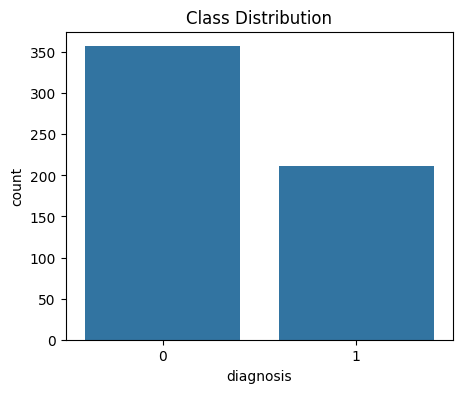

In [8]:
# class distribution
plt.figure(figsize=(5, 4))
sns.countplot(x='diagnosis', data = df)
plt.title("Class Distribution")
plt.show()

In [9]:
print("Class distribution:\n", df["diagnosis"].value_counts(normalize=True))

Class distribution:
 diagnosis
0    0.627417
1    0.372583
Name: proportion, dtype: float64


The classes are moderately imbalanced (37% malignant, 63% benign).

#### 2.2.3 Feature Distributions

**Histograms**

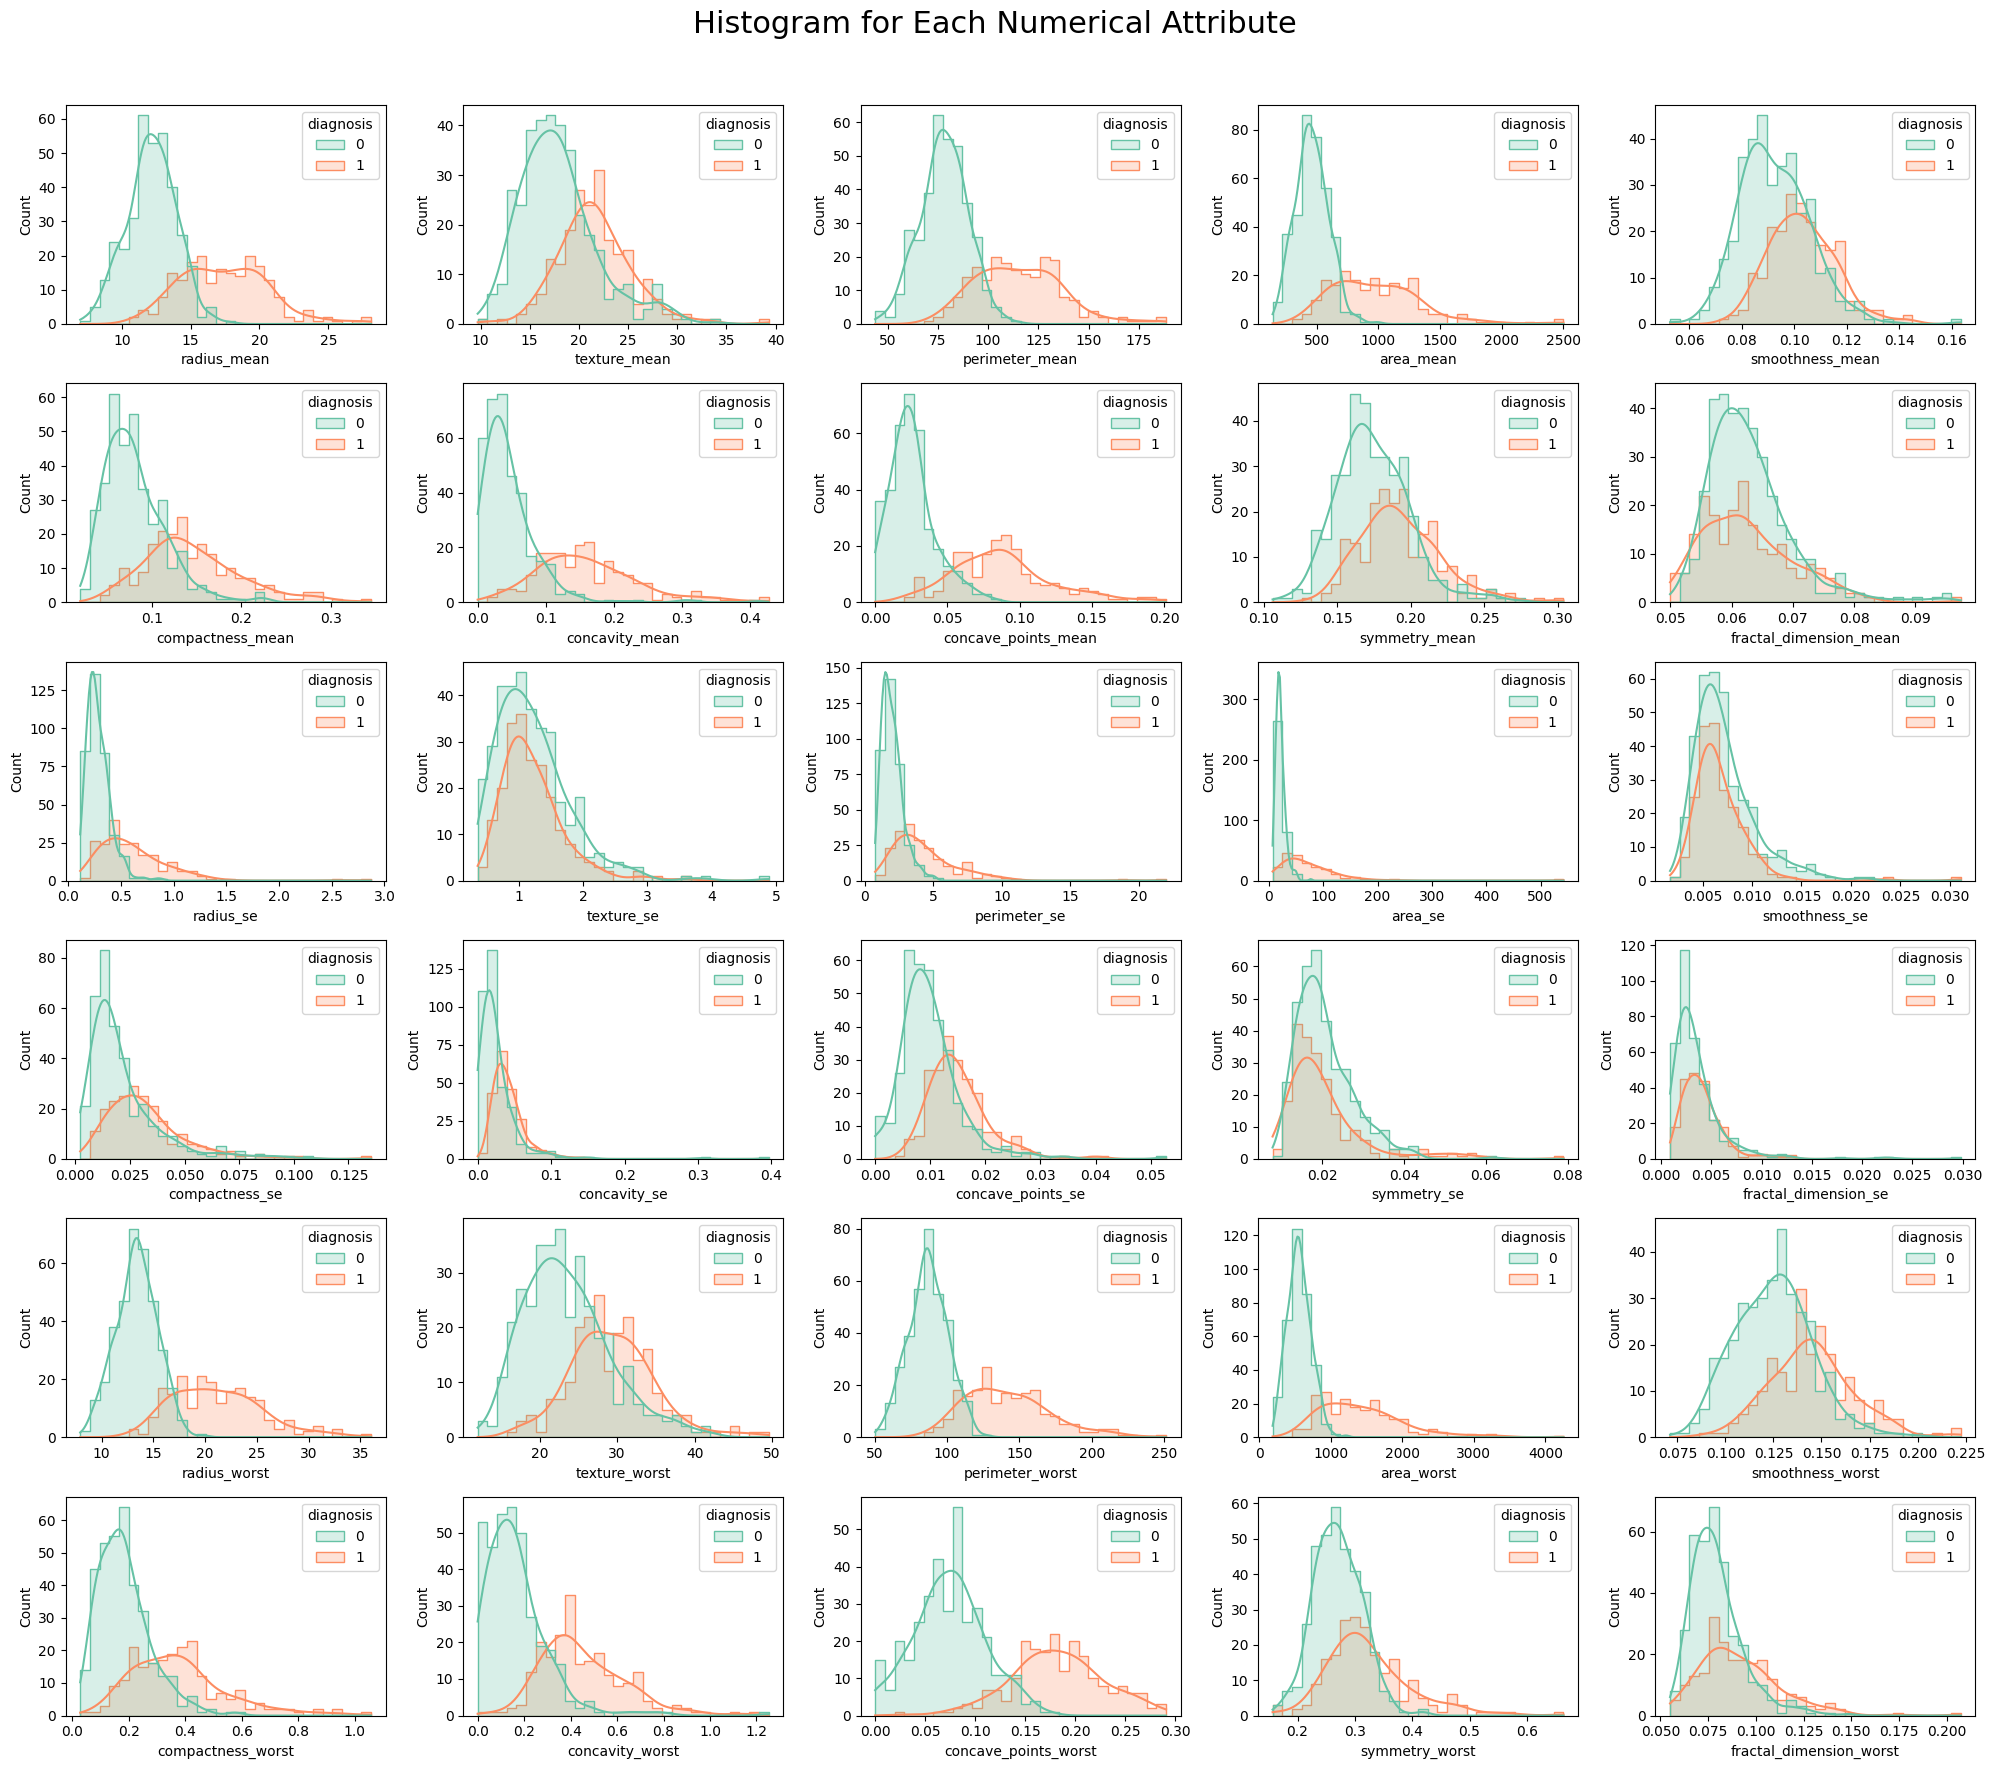

In [10]:
features = df.columns[2:]
n_cols = 5
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))

for i, feature in enumerate(features):
    ax = axes[i // n_cols, i % n_cols]
    sns.histplot(data=df, x=feature, hue="diagnosis", palette="Set2", bins=30, kde=True, ax=ax, element="step")

plt.suptitle("Histogram for Each Numerical Attribute", fontsize = 22)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Histograms show distribution shifts between benign and malignant in many features:
- Attributes have very different scales
- Many histograms are skewed right, especially area- and perimeter-related features

**Boxplots**


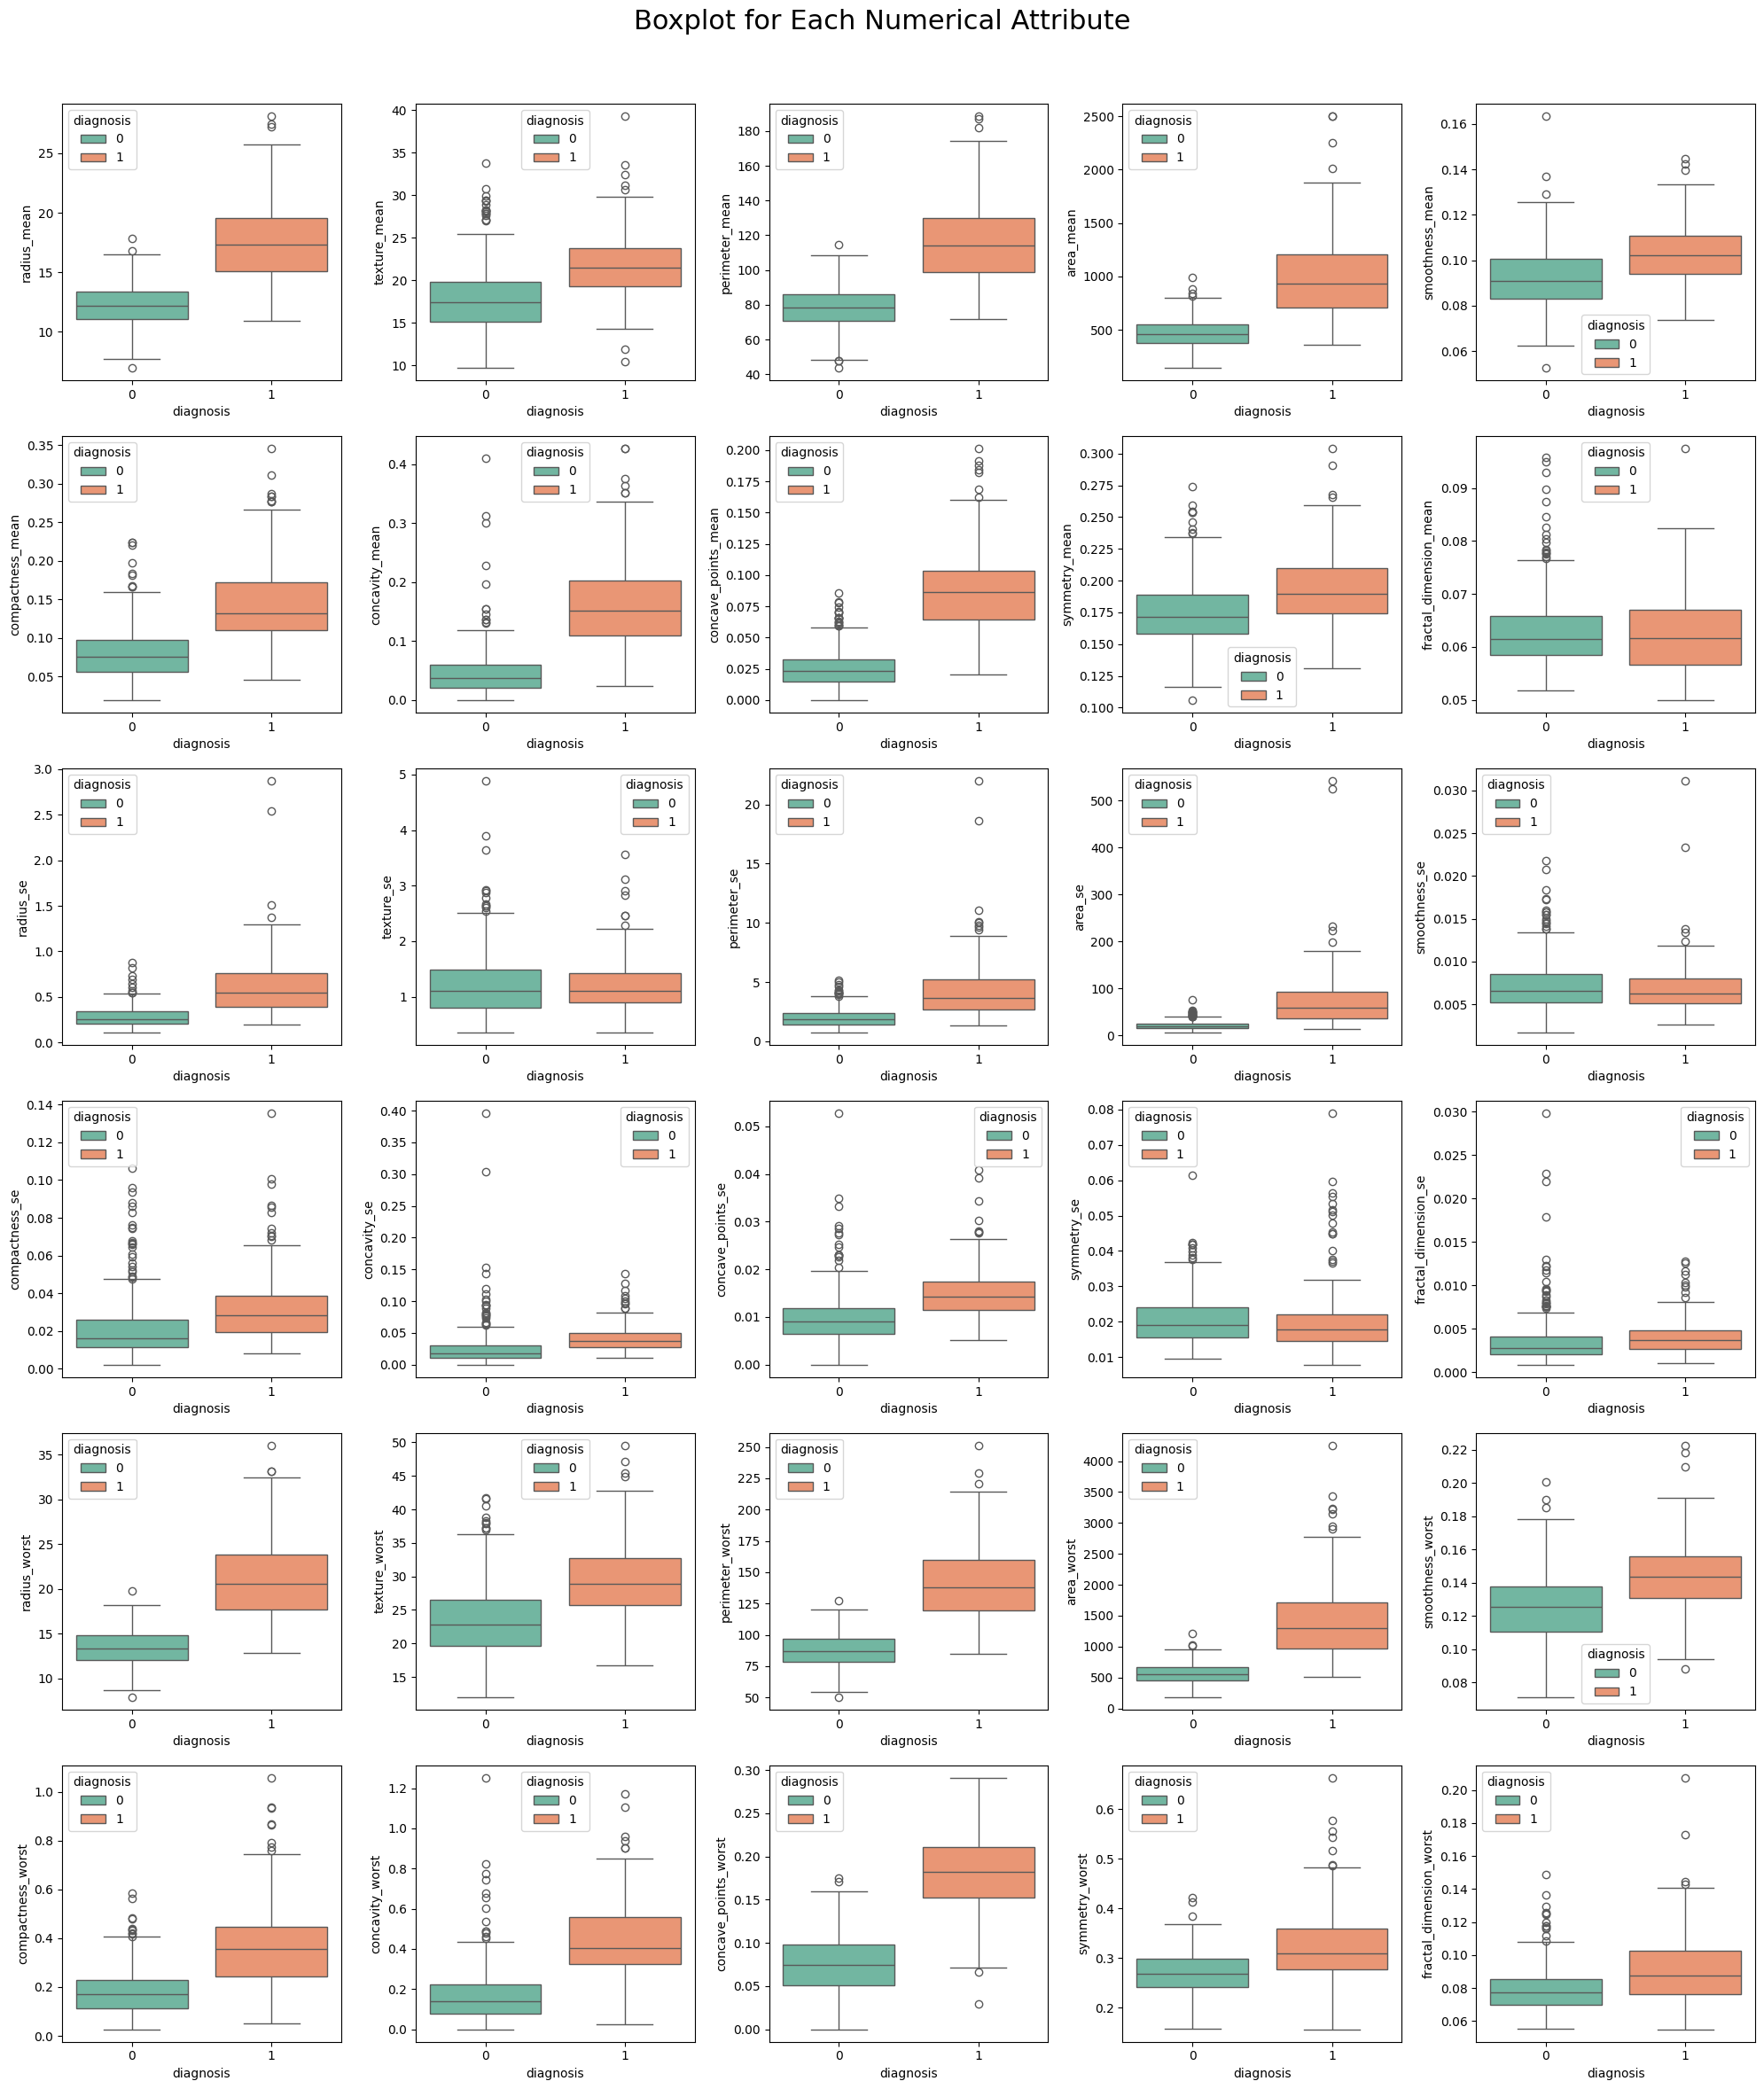

In [11]:
plt.figure(figsize=(20, 4 * n_rows))

for i, feature in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x="diagnosis", y=feature, data=df, hue="diagnosis", palette="Set2")

plt.suptitle("Boxplot for Each Numerical Attribute", fontsize = 22)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Key observations**
- Malignant cases tend to have higher values for many features (e.g., radius_mean, area_mean) and greater variability.
- SE (standard error) features show more overlap, though some (e.g., radius_se) still skew higher for malignant cases.
- Outliers are more common in malignant samples, indicating greater variation in tumor shape and size.

#### 2.2.4 Pairwise Relationships

In [12]:
mean_features = [col for col in df.columns if "_mean" in col]
se_features = [col for col in df.columns if "_se" in col]
worst_features = [col for col in df.columns if "_worst" in col]

To better understand feature relationships, I examine pairwise scatterplots
separately for mean, SE, and worst feature groups.

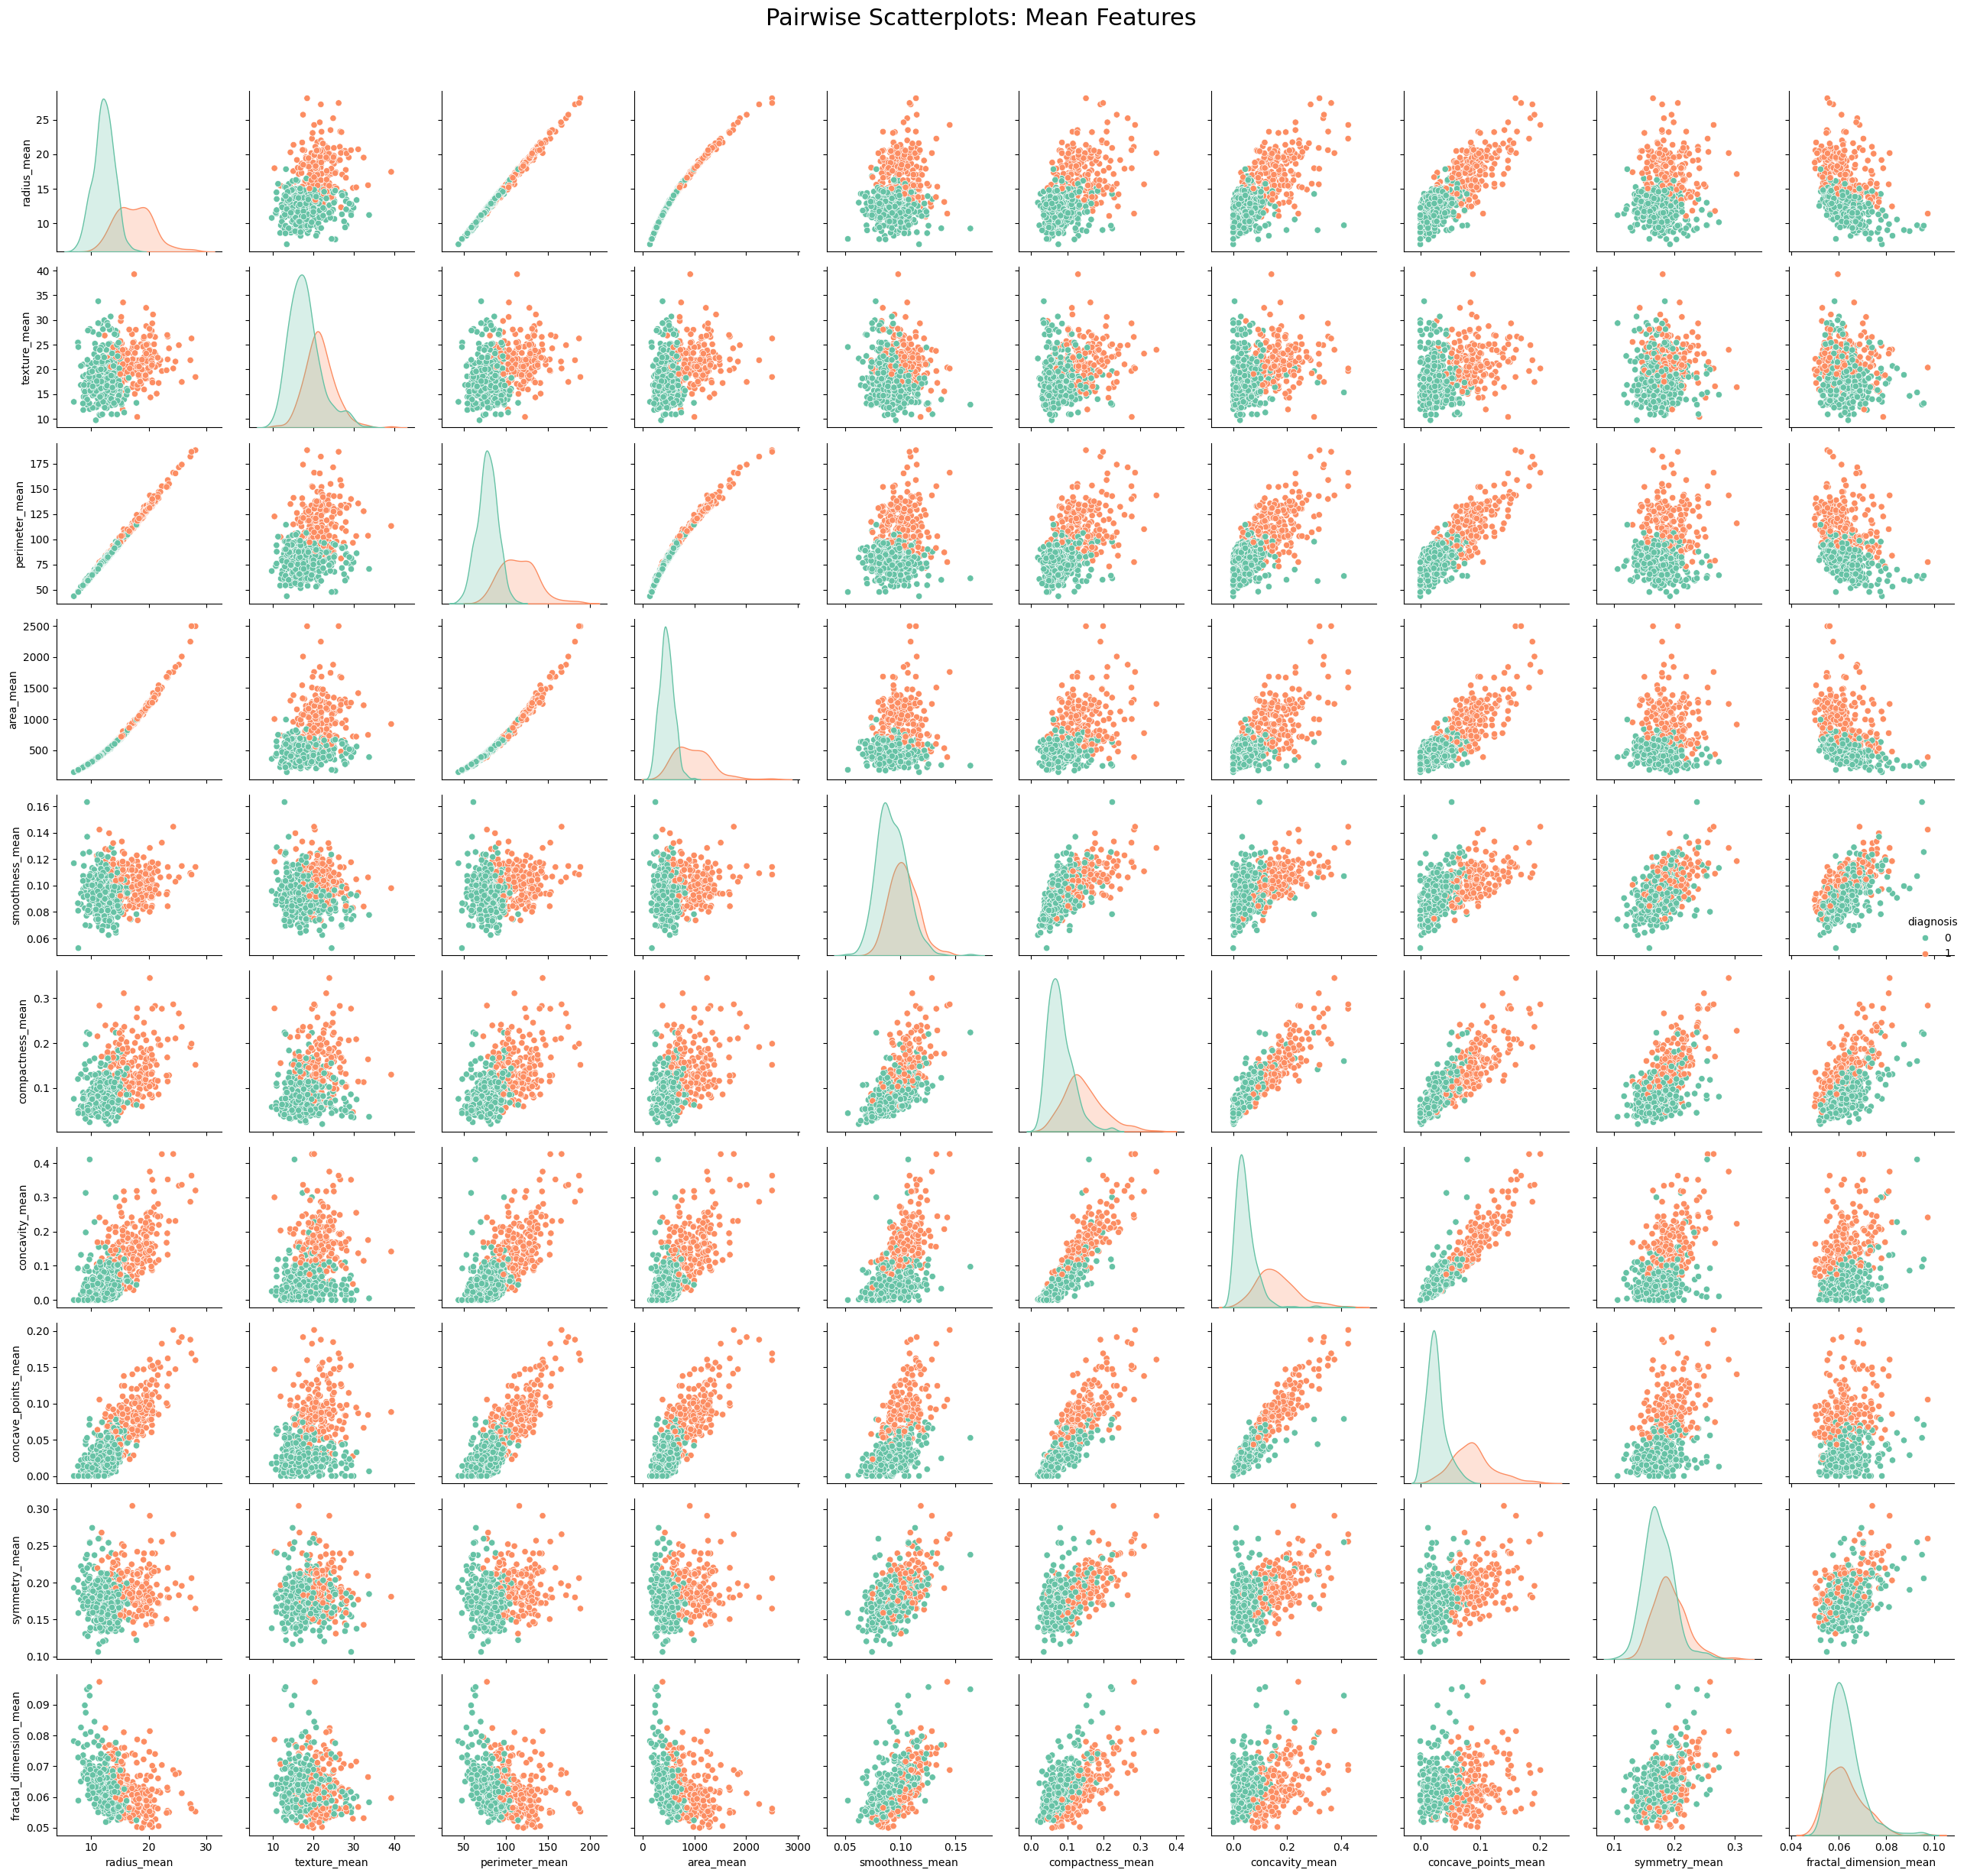

In [13]:
sns.pairplot(df[["diagnosis"] + mean_features], hue="diagnosis", palette="Set2")
plt.suptitle("Pairwise Scatterplots: Mean Features", fontsize = 22)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- Strong linear correlations appear between radius_mean, perimeter_mean, and area_mean
- Malignant cases (orange) form distinct clusters in several 2D planes, indicating good class separation.

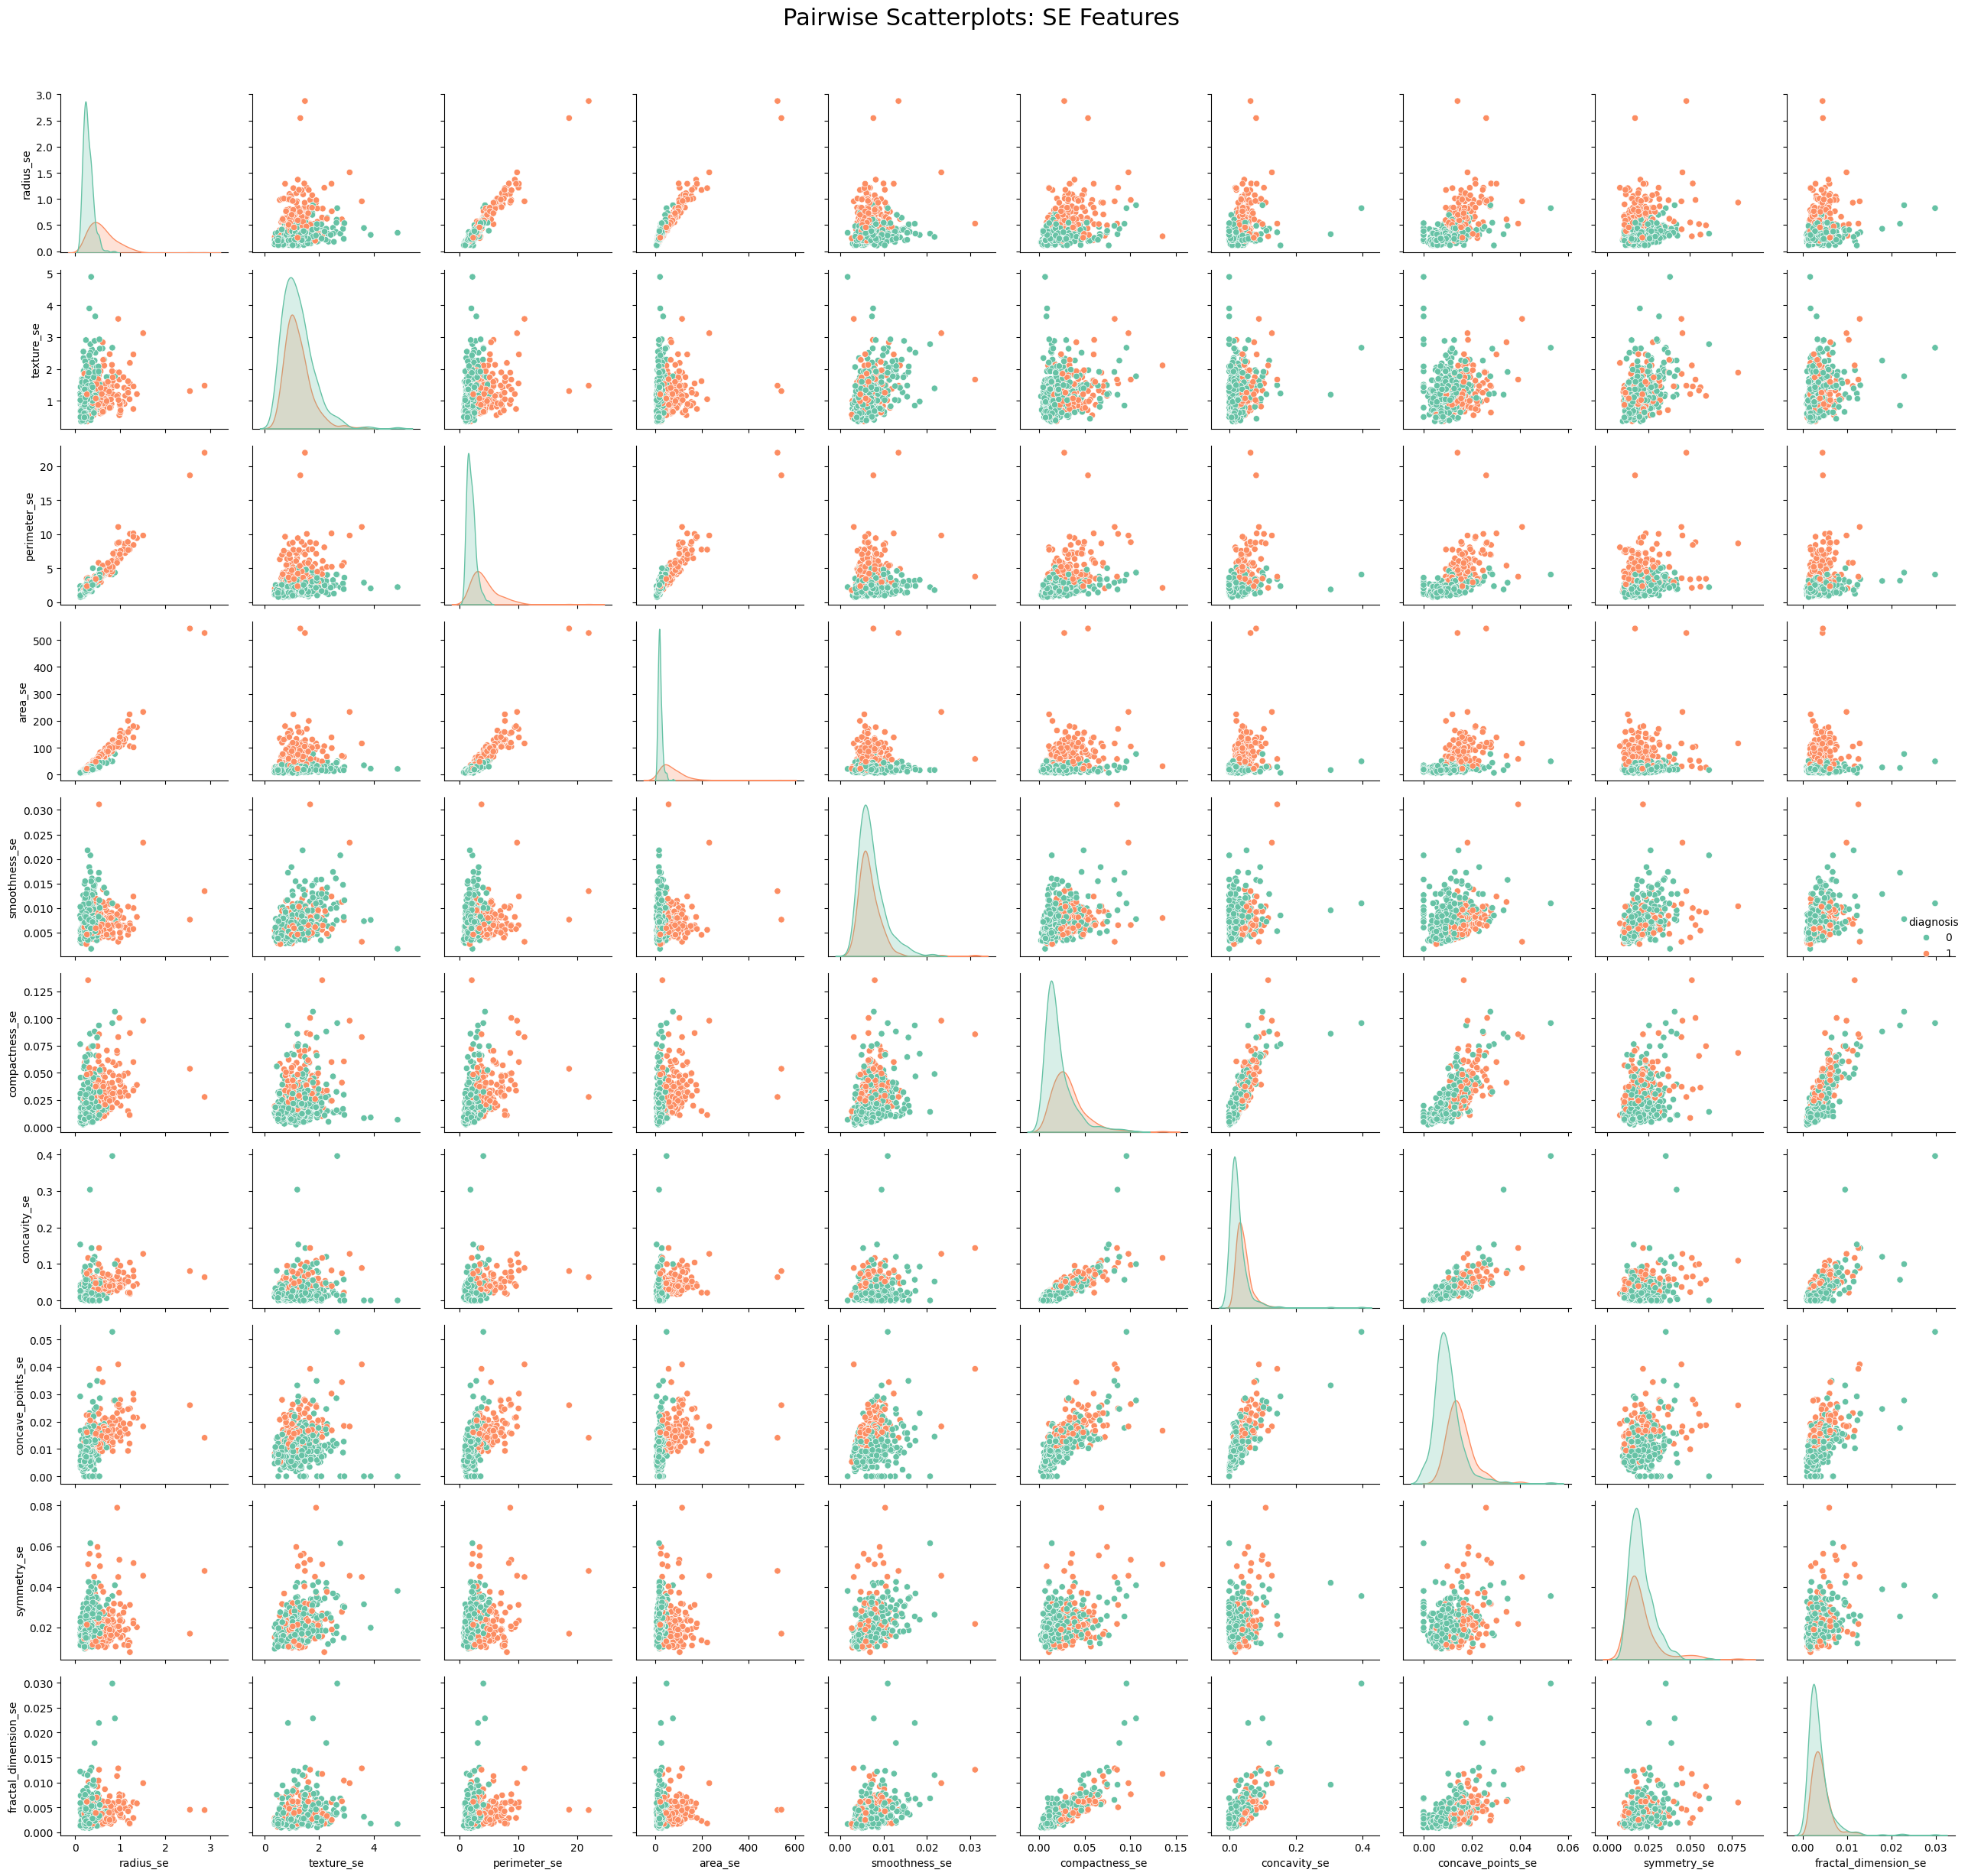

In [14]:
sns.pairplot(df[["diagnosis"] + se_features], hue="diagnosis", palette="Set2")
plt.suptitle("Pairwise Scatterplots: SE Features", fontsize = 22)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- SE features show more diffuse clusters with weaker separation between classes.
- Many features are tightly grouped near zero, indicating low variability.

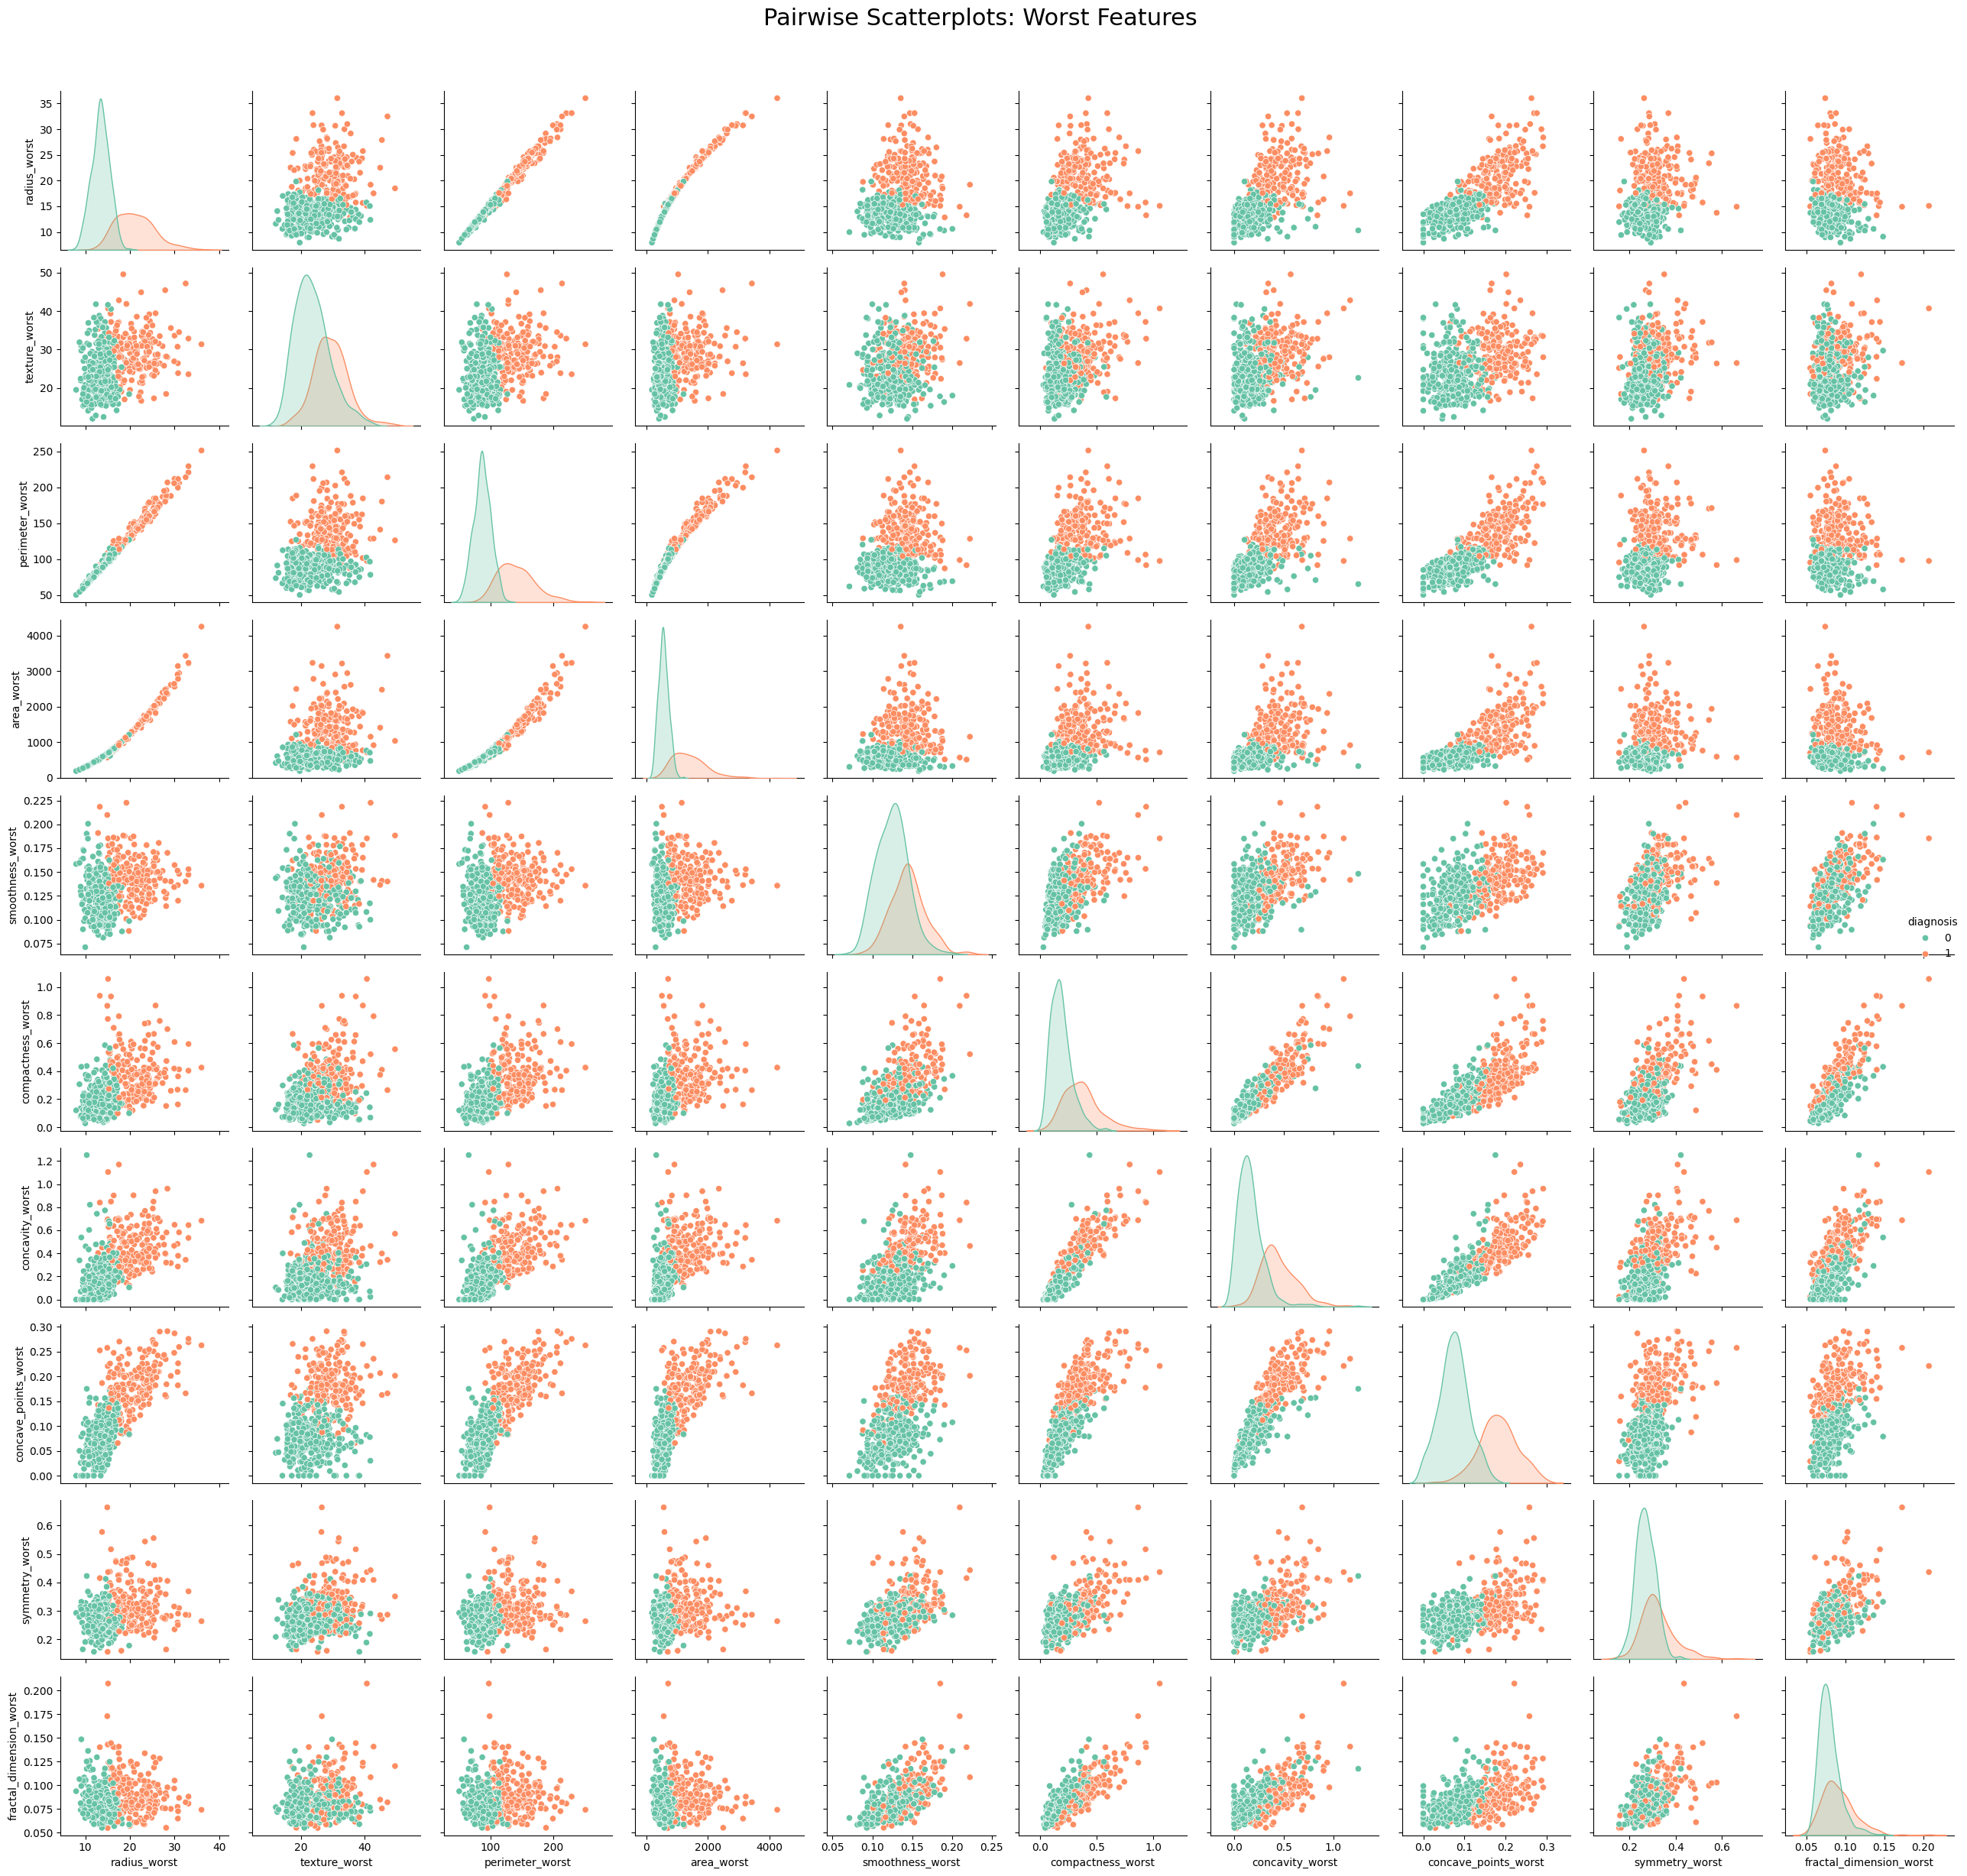

In [15]:
sns.pairplot(df[["diagnosis"] + worst_features], hue="diagnosis", palette="Set2")
plt.suptitle("Pairwise Scatterplots: Worst Features", fontsize = 22)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- Similar to mean features, strong correlations exist (e.g., between radius_worst and area_worst)
- Class separation is clearer here than in SE features

#### 2.2.5 Feature Correlations

I plotted the correlation matrix to examine pairwise relationships among numerical features.

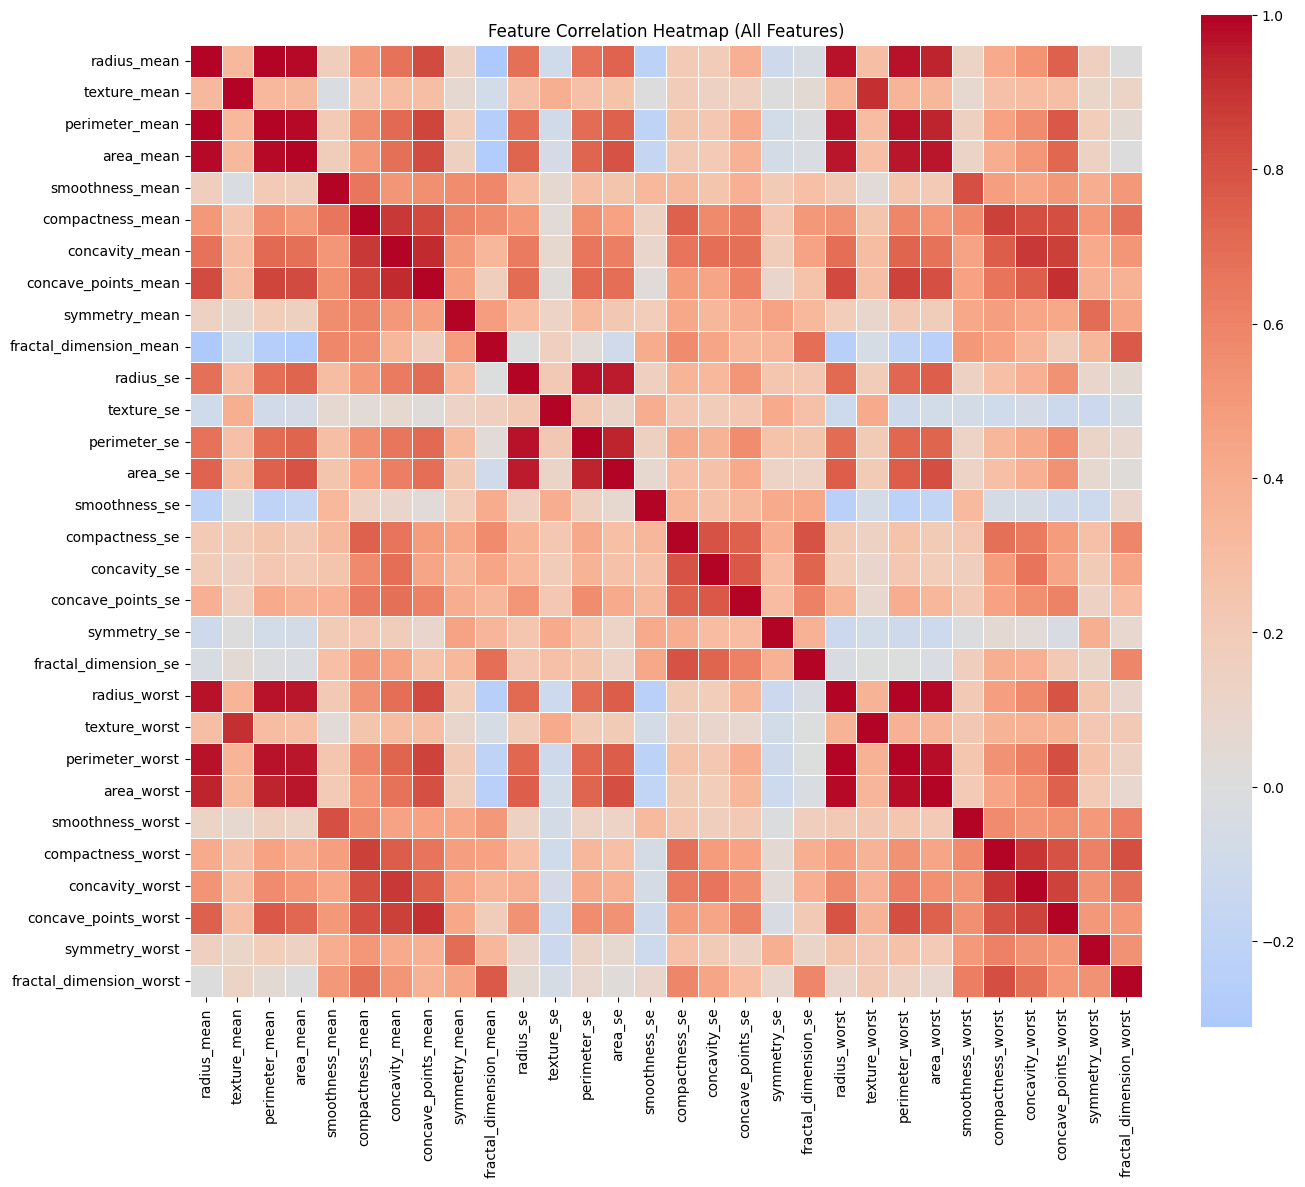

In [16]:
plt.figure(figsize=(14, 12))
sns.heatmap(
    df.iloc[:, 2:].corr(),
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)
plt.title("Feature Correlation Heatmap (All Features)")
plt.tight_layout()
plt.show()

- Many features show strong pairwise correlations, especially within the same group (mean, SE, worst). For example, `radius_mean`, `perimeter_mean`, and `area_mean` are highly correlated.
- Correlation filtering (e.g., |r| > 0.9) can help reduce dimensionality and improve model efficiency.

In [17]:
# Identify highly correlated features (|r| > 0.9)
corr_matrix = df.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr = [
    column for column in upper.columns
    if any(upper[column] > 0.9)
]

for col in high_corr:
    print(col)

perimeter_mean
area_mean
concave_points_mean
perimeter_se
area_se
radius_worst
texture_worst
perimeter_worst
area_worst
concave_points_worst


These highly correlated features will be examined further in Section 2.4.

#### 2.2.6 Cleanup

The `id` column is purely an identifier and has no predictive value, so it is removed before modeling.

In [18]:
# Drop unnecessary columns

df.drop(columns=['id'], inplace=True)

**Key observations:**
- Strong feature correlations could slow training or introduce redundancy.
- While feature selection may be beneficial, I first train the SVM using all features with proper scaling.
  Reduced feature sets are evaluated later for comparison (refer to Section 2.4).

### 2.3 Train–Test Split with Stratification

To prepare for modeling, the dataset is split into a training set (80%) and a test set (20%).

Random sampling is often sufficient for large and well-balanced datasets. However, in this case, the dataset contains only 569 instances and exhibits a moderately imbalanced class distribution (approximately 63% benign and 37% malignant). To reduce the risk of sampling bias, stratified splitting is used to preserve class proportions in both the training and test sets.



In [19]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print("Class distribution in training set:\n", y_train.value_counts(normalize=True))
print("Class distribution in test set:\n", y_test.value_counts(normalize=True))

Training set size: 455
Test set size: 114
Class distribution in training set:
 diagnosis
0    0.626374
1    0.373626
Name: proportion, dtype: float64
Class distribution in test set:
 diagnosis
0    0.631579
1    0.368421
Name: proportion, dtype: float64


This results in 455 training samples and 114 test samples.
The class ratios in both sets closely match the original distribution, with benign cases accounting for approximately 63% and malignant cases for approximately 37%.

### 2.4 Model Training and Hyperparameter Tuning

#### 2.4.1 Why SVM?

Support Vector Machines (SVM) are well-suited for binary classification, particularly in high-dimensional feature spaces such as this dataset (30 features). With an RBF kernel, SVM can model nonlinear decision boundaries effectively.

Key features:
- Finds a maximum-margin boundary, which improves generalization
- RBF kernel captures nonlinear relationships
- Sensitive to feature scaling


#### 2.4.2 Setup: Preprocessing, Metric, and Grid Design

**Preprocessing**

SVM is sensitive to feature scaling. I used `MinMaxScaler` to scale all features into the [0, 1] range, which is appropriate for distance-based models such as SVM.

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

svm_pipeline = make_pipeline(MinMaxScaler(), SVC(random_state=42))

**Stratified Cross-Validation**

Since the dataset is moderately imbalanced, stratified cross-validation is used to preserve class proportions in each fold.

**Evaluation Metric**

Recall is used as the primary scoring metric during hyperparameter tuning. In medical diagnosis, false negatives are more harmful than false positives, so maximizing recall (especially for malignant cases) is more important.

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

def recall_gridsearch(pipeline, param_grid, X_train=X_train, y_train=y_train):
    model = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='recall',
        refit=True,
    )
    model.fit(X_train, y_train)

    print(f"Optimal hyperparameter values: {model.best_params_}\n")

    cv_df = pd.DataFrame({
        'Fold': range(1, 6),
        'Validation Recall': [f'{model.cv_results_[f"split{i}_test_score"][model.best_index_]:.3f}' for i in range(5)]
    })
    print(cv_df.to_string(index=False) + '\n')

    return model

#### 2.4.3 First Grid Search (Base)

I first run a 3×3 grid using stratified 5-fold cross-validation to identify an appropriate kernel type:

- C: [0.1, 1, 10] — regularization strength (larger values correspond to a harder margin)
- kernel: ['linear', 'rbf', 'poly']

This results in 9 × 5 = 45 total model fits.

In [22]:
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly'],
}
model_1 = recall_gridsearch(svm_pipeline, param_grid)

Optimal hyperparameter values: {'svc__C': 10, 'svc__kernel': 'rbf'}

 Fold Validation Recall
    1             0.912
    2             1.000
    3             0.971
    4             0.971
    5             0.971



The optimal hyperparameter values are: {'svc__C': 10, 'svc__kernel': 'rbf'}. The selected model showed stable recall performance across cross-validation folds.

#### 2.4.4 Second Grid Search (RBF Tuning)

Since the RBF kernel was selected in the initial search, I further tuned the kernel width parameter γ.

I ran another 3×3 grid with stratified 5-fold cross-validation:
- C: [0.1, 1, 10] — regularization strength
- gamma: [0.01, 0.1, 1] — kernel width (smaller values imply wider influence)

This again results in 9 × 5 = 45 total model fits.

In [23]:
param_grid_rbf = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.01, 0.1, 1],
}
model_2 = recall_gridsearch(svm_pipeline, param_grid_rbf)

Optimal hyperparameter values: {'svc__C': 10, 'svc__gamma': 1}

 Fold Validation Recall
    1             0.912
    2             1.000
    3             0.971
    4             0.971
    5             0.971



The optimal hyperparameter values are: {'svc__C': 10, 'svc__gamma': 1}. The tuned RBF model demonstrated consistent recall performance across validation folds.

#### 2.4.5 Feature Selection

**Correlation-Based Feature Reduction**

As shown in the EDA, several features in the dataset exhibit strong linear correlations. This redundancy may slow down training or introduce unnecessary noise for kernel-based models such as SVM.

To investigate this, I removed a subset of features with high pairwise correlation (|r| > 0.9), identified in Section 2.2.5.

In [24]:
X_train_reduced = X_train.drop(columns=high_corr)
X_test_reduced = X_test.drop(columns=high_corr)

I then retrained the SVM model using the same preprocessing pipeline and grid search configuration as before:

In [25]:
model_reduced = recall_gridsearch(
    svm_pipeline,
    param_grid_rbf,
    X_train_reduced, y_train
)

Optimal hyperparameter values: {'svc__C': 10, 'svc__gamma': 1}

 Fold Validation Recall
    1             0.882
    2             1.000
    3             0.971
    4             0.941
    5             0.971



The results show that the reduced-feature model maintains comparable performance to the full-feature model. This suggests that the removed features do not contribute significantly to classification performance. Therefore, I selected the reduced-feature model as the final SVM classifier.

The final model configuration is:
- SVM with RBF kernel
- C = 10, γ = 1
- 20 features after correlation-based filtering
- Tuned using 5-fold stratified cross-validation with recall as the optimisation metric

In [26]:
best_model = model_reduced.best_estimator_

**Training Set Performance (Default Threshold)**

Accuracy : 0.987
Recall   : 0.965
Precision: 1.000



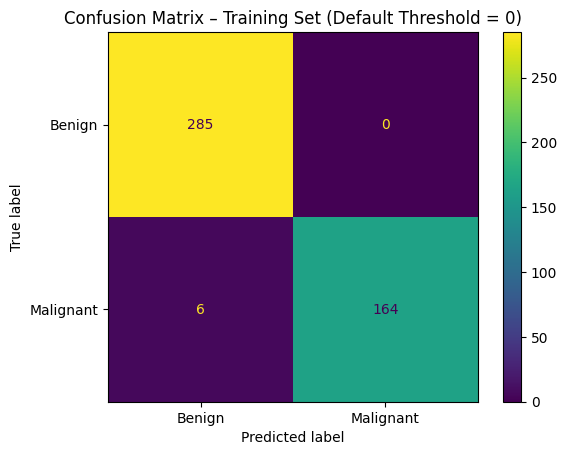

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score

y_pred_train_default = best_model.predict(X_train_reduced)
print(f"Accuracy : {accuracy_score(y_train, y_pred_train_default):.3f}")
print(f"Recall   : {recall_score(y_train, y_pred_train_default, pos_label=1):.3f}")
print(f"Precision: {precision_score(y_train, y_pred_train_default, pos_label=1):.3f}\n")

ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train_default,
    display_labels=["Benign", "Malignant"],
    cmap="viridis"
)
plt.title("Confusion Matrix – Training Set (Default Threshold = 0)")
plt.show()

The confusion matrix on the training set shows that the final SVM model achieves near-perfect classification performance. It correctly identifies all benign cases, while misclassifying 6 malignant samples as benign.

#### 2.4.6 Threshold Adjustment

**Precision–Recall Trade-off**

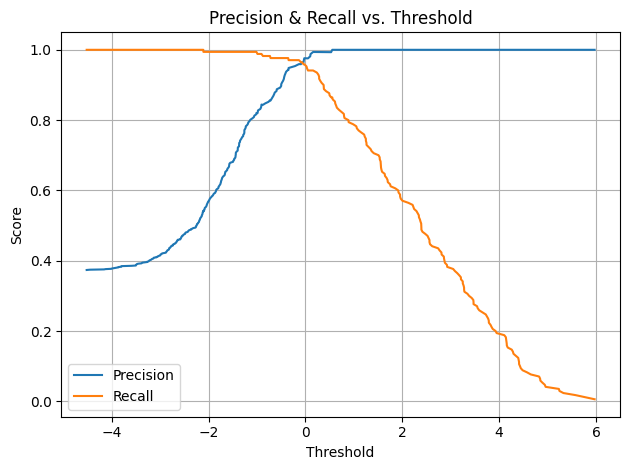

In [28]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

# Get decision scores from training set using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_predict(
    model_reduced.best_estimator_,
    X_train_reduced,
    y_train,
    cv=cv,
    method="decision_function"
)

precisions, recalls, thresholds = precision_recall_curve(
    y_train,
    scores,
    pos_label=1
)

plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Lowering the decision threshold increases recall at the cost of reduced precision. With the default decision threshold (0), the SVM achieves very high precision but slightly lower recall. In medical diagnosis, missing a malignant case is more costly than producing false positives, so recall is prioritised.

**Threshold Selection**

To reflect this objective, I identify the optimal threshold that achieves a recall of at least 0.98 on the training set using cross-validation:

In [29]:
target_recall = 0.98
valid_idx = np.where(recalls >= target_recall)[0]
best_idx = valid_idx[np.argmax(precisions[valid_idx])]
opt_threshold = thresholds[best_idx]
opt_precision = precisions[best_idx]
opt_recall = recalls[best_idx]

print(f"Optimal threshold (recall ≥ {target_recall}): {opt_threshold:.2f}")
print(f"Recall   : {opt_recall:.3f}")
print(f"Precision: {opt_precision:.3f}")

Optimal threshold (recall ≥ 0.98): -0.73
Recall   : 0.982
Precision: 0.856


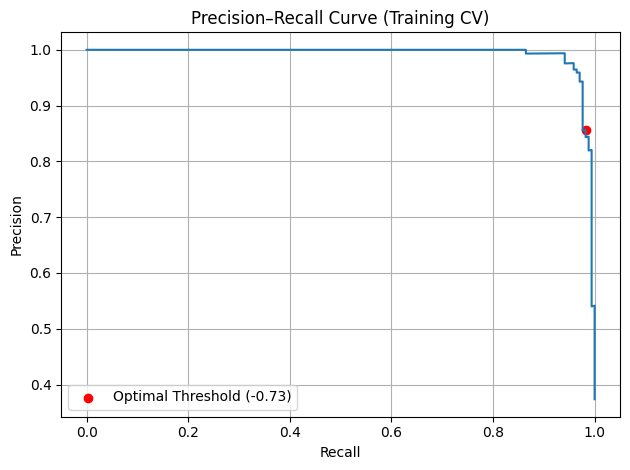

In [30]:
plt.plot(recalls, precisions)
plt.scatter(opt_recall, opt_precision, color="red", label=f"Optimal Threshold ({opt_threshold:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluation on Training Set

In [31]:
train_scores = model_reduced.decision_function(X_train_reduced)
y_train_adjusted = (train_scores >= opt_threshold).astype(int)

print(f"Training Set Performance (Threshold = {opt_threshold:.2f})")
print(f"Accuracy : {accuracy_score(y_train, y_train_adjusted):.3f}")
print(f"Recall   : {recall_score(y_train, y_train_adjusted):.3f}")
print(f"Precision: {precision_score(y_train, y_train_adjusted):.3f}\n")

Training Set Performance (Threshold = -0.73)
Accuracy : 0.976
Recall   : 0.988
Precision: 0.949



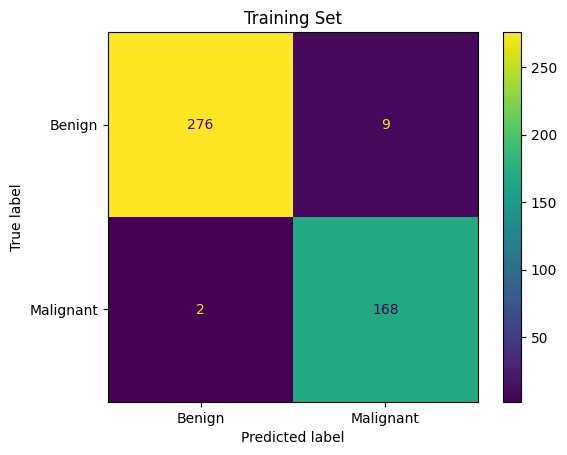

In [32]:
ConfusionMatrixDisplay.from_predictions(
    y_train,
    y_train_adjusted,
    display_labels=["Benign", "Malignant"],
)
plt.title("Training Set")
plt.show()

Final model: I selected the reduced-feature SVM model with an RBF kernel (C = 10, γ = 1) and an adjusted decision threshold of −0.73.

### 2.5 Test Set Evaluation

In [33]:
test_scores = model_reduced.decision_function(X_test_reduced)
y_pred_adjusted = (test_scores >= opt_threshold).astype(int)

print(f"Threshold: {opt_threshold:.2f}")
print(f"Accuracy : {accuracy_score(y_test, y_pred_adjusted):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred_adjusted, pos_label=1):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_adjusted, pos_label=1):.3f}\n")

Threshold: -0.73
Accuracy : 0.956
Recall   : 0.976
Precision: 0.911



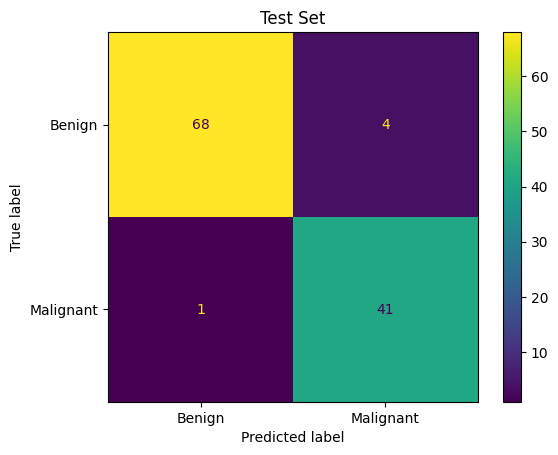

In [34]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_adjusted,
    display_labels=["Benign", "Malignant"],
    cmap="viridis"
)
plt.title("Test Set")
plt.show()

Using the selected decision threshold (−0.73), the model achieves the following performance on the test set: Accuracy = 0.956, Recall = 0.976, and Precision = 0.911.

The confusion matrix shows only one false negative, successfully identifying 41 out of 42 malignant cases. This aligns with the task’s objective of minimizing false negatives. The slight reduction in precision (four false positives) is acceptable, as recall is prioritised in medical screening contexts where missing a malignant case is more costly.

### 2.6 Summary and Discussion


#### 2.6.1 Can This Be Used for Screening?

Partially — with important limitations.

The final SVM model (RBF kernel, C = 10, γ = 1, reduced feature set) achieved strong performance on the test set, with Recall = 0.976, Precision = 0.911, Accuracy = 0.956, and only one false negative among 42 malignant cases. This indicates that the model is effective at identifying most malignant samples while maintaining an acceptable false-positive rate.

However, several limitations prevent direct clinical deployment:
- The dataset is relatively small and clean, whereas real clinical data are typically larger, noisier, and more heterogeneous.
- Features are limited to biopsy-derived measurements; real-world diagnosis often involves additional clinical, demographic, and imaging information.
- Despite high recall, the model still missed a malignant case, which is critical in screening scenarios.

Overall, the model shows potential as a **decision-support tool** to flag high-risk cases for further examination, rather than as a standalone diagnostic system.

To move toward clinical applicability, future work would require:
- Training on larger and more diverse datasets
- Incorporating multimodal clinical features
- Evaluating performance in real-world screening settings

It is also worth noting that SVMs do not scale efficiently to very large datasets, which may limit deployment. In such settings, alternatives such as SGD-based classifiers or tree-based ensemble models may be more suitable.

In summary, the recall-oriented design aligns well with the requirements of high-sensitivity medical screening, but the model is not ready for real-world deployment.

#### 2.6.2 Precision–Recall Curve

The precision–recall (PR) curve illustrates the trade-off between precision and recall across different decision thresholds. In Section 2.4.6, I used the PR curve based on cross-validated training predictions to select an optimal threshold (−0.73) that prioritised recall.

Here, I plot the PR curve on the test set to evaluate how this threshold generalises to unseen data. The highlighted point corresponds to the selected threshold, achieving high recall with acceptable precision and successfully minimising false negatives.

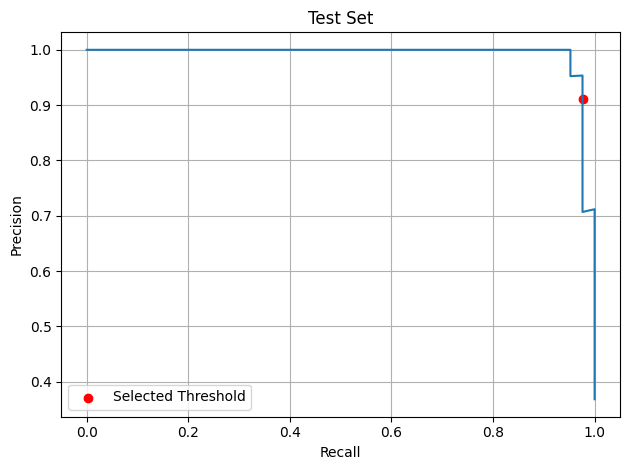

In [35]:
# get test scores
test_scores = model_reduced.decision_function(X_test_reduced)

precisions_test, recalls_test, thresholds_test = precision_recall_curve(y_test, test_scores, pos_label=1)

opt_idx = np.argmin(np.abs(thresholds_test - opt_threshold))
opt_recall = recalls_test[opt_idx]
opt_precision = precisions_test[opt_idx]

plt.plot(recalls_test, precisions_test)
plt.scatter(opt_recall, opt_precision, color="red", label="Selected Threshold")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Voting Classifier

### 3.1 Motivation and Setup

This section evaluates whether combining multiple classifiers using a voting strategy can improve classification performance on a medical dataset.

While the previous section focused on optimising a single SVM model with recall-oriented threshold adjustment, ensemble methods offer an alternative approach by aggregating the strengths of different models. In particular, voting classifiers can reduce variance and improve robustness, which is desirable in imbalanced medical classification tasks.

The voting classifier is evaluated on the same Breast Cancer Wisconsin Diagnostic dataset, using the same training and test splits as in Section 2. This ensures a fair comparison between individual classifiers and the ensemble model.

### 3.2 Base Models
I train three base classification models on the training data:
- Logistic Regression
- Random Forest
- Support Vector Machine (SVM)

**Model 1: Logistic Regression**  
Logistic Regression is a linear model for binary classification that estimates class probabilities using a logistic function. Due to its reliance on linear decision boundaries, feature scaling is important for stable optimisation.

Hyperparameters:
- `C=1.0`: inverse of regularisation strength (default)  
- `penalty='l2'`: L2 regularization (default)  
- `max_iter=1000`: increased from the default to ensure convergence
- `random_state=42`: ensures reproducibility

**Model 2: Random Forest**  

Random Forest is an ensemble of decision trees trained on random subsets of the data and features. Predictions are made by aggregating the outputs of individual trees through majority voting.

As a tree-based model, Random Forest is not sensitive to feature scaling, so no standardisation is applied.

Hyperparameters:
- `n_estimators=100`: number of trees (default)  
- `criterion='gini'`: splitting criterion (default)  
- `max_depth=None`: trees grow until leaves are pure or too small to split
- `min_samples_split=2`: minimum samples required to split a node  
- `random_state=42`: ensures reproducibility

**Model 3: Support Vector Machine (SVM)**  
Support Vector Machine constructs a decision boundary that maximises the margin between classes. An RBF kernel is used to capture nonlinear relationships in the feature space.

Feature scaling is essential for SVM, as the optimisation process and kernel computation are sensitive to feature magnitudes.

Hyperparameters:
- `C=1.0`: regularization parameter (default)  
- `kernel='rbf'`: radial basis function kernel for nonlinear decision boundaries
- `gamma='scale'`: kernel coefficient (default)  
- `probability=True`: enables probability estimates required for soft voting
- `random_state=42`: ensures reproducibility


In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# 1) Logistic Regression (needs scaling)
log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=42)
)
log_reg.fit(X_train, y_train)

# 2) Random Forest (no scaling needed)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# 3) SVM (needs scaling; probability=True for soft voting later)
svm_clf = make_pipeline(
    StandardScaler(),
    SVC(probability=True, random_state=42)
)
svm_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True, random_state=42))])

### 3.3 Voting Classifier (Soft Voting)

A Voting Classifier combines predictions from multiple base classifiers to produce a final decision.

**Hard voting**: the predicted class is determined by majority vote among base models.

**Soft voting** predicted class probabilities from each model are averaged, and the class with the highest average probability is selected.

Soft voting takes model confidence into account and often performs better when classifiers are well-calibrated. To enable soft voting, all base models must provide class probability estimates. In this case, the SVM classifier is initialized with `probability=True`.

Using diverse base learners helps improve generalization:
- Logistic Regression provides a linear decision boundary
- Random Forest captures nonlinear interactions through ensembles of trees
- SVM (RBF kernel) models complex nonlinear boundaries

By aggregating these different perspectives, the voting classifier can reduce variance and often outperform individual models. Equal weights are used for all base models (default setting).



In [37]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ("lr", log_reg),
        ("rf", rf_clf),
        ("svm", svm_clf),
    ],
    voting="soft"
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(max_iter=1000,
                                                                  random_state=42))])),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svm',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(probability=True,
                                                   random_state=42))]))],
                 voting='soft')

### 3.4 Evaluate Performance



#### 3.4.1 Performance Metrics
I evaluate each model on the test set using precision, recall, and F1-score (with malignant = 1 as the positive class).

In [38]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

models = [log_reg, rf_clf, svm_clf, voting_clf]
model_names = ["Logistic Regression", "Random Forest", "SVM", "Voting Classifier"]

rows = []
for name, model in zip(model_names, models):
    y_pred = model.predict(X_test)
    rows.append({
        "Model": name,
        "Precision": precision_score(y_test, y_pred, pos_label=1),
        "Recall": recall_score(y_test, y_pred, pos_label=1),
        "F1-Score": f1_score(y_test, y_pred, pos_label=1),
    })

perf_df = pd.DataFrame(rows).sort_values(by="Recall", ascending=False)
print(perf_df)

                 Model  Precision    Recall  F1-Score
3    Voting Classifier      1.000  0.976190  0.987952
0  Logistic Regression      0.975  0.928571  0.951220
1        Random Forest      1.000  0.928571  0.962963
2                  SVM      1.000  0.928571  0.962963


#### 3.4.2 Confusion Matrices

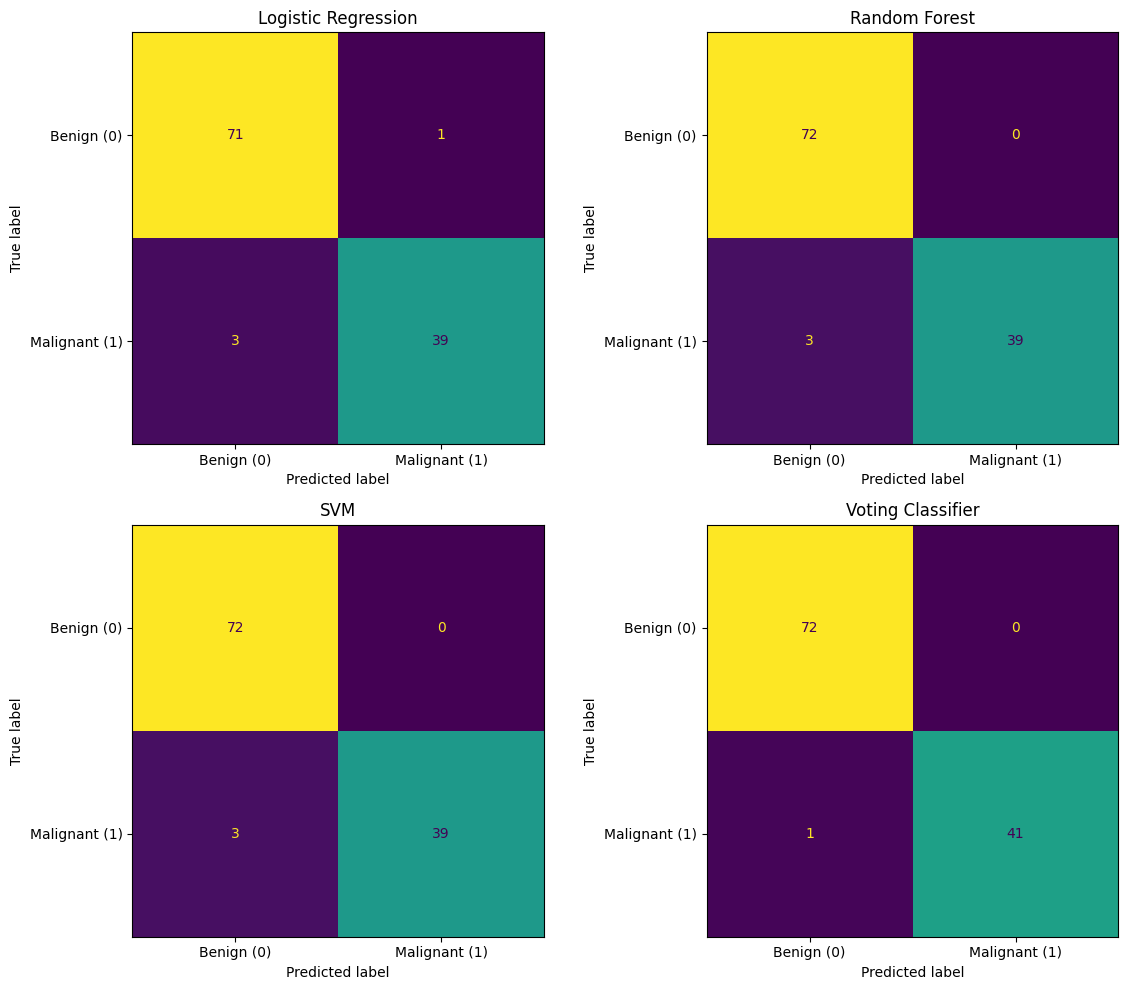

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for ax, name, model in zip(axes, model_names, models):
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        labels=[0, 1],
        display_labels=["Benign (0)", "Malignant (1)"],
        ax=ax,
        colorbar=False
    )
    ax.set_title(name)

plt.tight_layout()
plt.show()

### 3.5 Results Investigation


#### (a) Model Comparison
Among the four models, the **Voting Classifier (soft voting)** achieves the best overall performance.
- It obtains the highest recall and F1-score, missing only one malignant case
- Random Forest and SVM perform similarly: both achieve perfect precision but slightly lower recall
- Logistic Regression performs the worst, with the lowest recall and F1-score

This result is consistent with expectations. A voting classifier often outperforms individual base models by aggregating predictions from diverse learners. In this case, diversity comes from combining a linear model (Logistic Regression), a tree-based model (Random Forest), and a kernel-based model (SVM), which tend to make different types of errors. By averaging their predictions, the voting classifier reduces variance and improves robustness.

**Soft voting** averages predicted class probabilities rather than relying on majority votes. This allows more confident predictions to have greater influence, which is especially beneficial for **imbalanced datasets** such as this one (~63% benign, ~37% malignant).

For comparison, I also evaluate **hard voting**, which predicts the class receiving the most votes.

In [40]:
voting_modes = ["soft", "hard"]

for mode in voting_modes:
    voting_clf.voting = mode
    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_test)

    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    print(f"Voting mode: {mode}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  F1-Score:  {f1:.3f}\n")

Voting mode: soft
  Precision: 1.000
  Recall:    0.976
  F1-Score:  0.988

Voting mode: hard
  Precision: 1.000
  Recall:    0.952
  F1-Score:  0.976



Hard voting results in lower recall than soft voting. This is expected, as hard voting ignores prediction confidence: if two models make incorrect predictions, the final decision is incorrect even when the third model is highly confident.

In medical diagnosis, **recall** is more important than overall accuracy. Missing a malignant case (false negative) is more harmful than producing a false positive. Therefore, prioritizing recall and F1-score is appropriate for this task.

#### (b) Advantages and Disadvantages of Using a Voting Classifier

**Advantages**
- Improved performance: Soft voting outperforms individual classifiers by aggregating diverse models
- Reduced overfitting: Combining linear, tree-based, and kernel-based models improves generalization
- Better handling of imbalance: Probability-based voting helps detect minority classes
- Lower variance: Errors made by individual models can be corrected by others

**Disadvantages**
- Model dependency: Base models must be reasonably strong and diverse
- Higher computational cost: Training and prediction are slower due to multiple models
- Probability requirement: Soft voting requires all models to support predict_proba()
- Reduced interpretability: Explaining individual predictions becomes more difficult
- Increased complexity: More models and hyperparameters to manage

Overall, the Voting Classifier demonstrates why ensemble methods are effective for sensitive tasks such as medical diagnosis. Future work could explore weighted voting, assigning higher weights to stronger base models, or combining ensemble methods with threshold tuning to further improve recall.

## 4. Conclusion
This notebook explores supervised classification on a medical dataset using SVM and a Voting Classifier.

After careful preprocessing, feature selection, and hyperparameter tuning, the SVM achieves high recall, which is critical in medical screening tasks where false negatives are costly. Adjusting the decision threshold using the precision–recall curve further improves sensitivity while maintaining acceptable precision.

The Voting Classifier, especially with soft voting, consistently outperforms individual models by combining diverse decision boundaries. This demonstrates how ensemble methods can improve robustness and reduce variance on imbalanced datasets.

Overall, the results highlight the importance of recall-oriented evaluation, probability-based decision making, and model diversity. While the models are not ready for real-world deployment, they provide a clear illustration of how SVMs and ensemble methods can be applied effectively to high-stakes classification problems.


## 5. Reference
- Géron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (2nd ed.). O’Reilly Media.
- Dua, D., & Graff, C. (2019). UCI Machine Learning Repository. University of California, Irvine, School of Information and Computer Sciences. https://doi.org/10.24432/C5DW2B